# 剪枝标准实践

In [31]:
import copy
import math
import random
import time

import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F

# 设置 matplotlib 使用支持负号的字体
plt.rcParams['font.family'] = 'DejaVu Sans'

In [32]:
# 定义一个LeNet网络
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device=device)

In [33]:
# 加载模型的状态字典
checkpoint = torch.load('../ch02/model.pt')
# 加载状态字典到模型
model.load_state_dict(checkpoint)
origin_model = copy.deepcopy(model)

In [34]:
# 绘制权重分布图
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(2,3, figsize=(10, 6))

    # 删除多余的子图
    fig.delaxes(axes[1][2])
    
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, 
                        color = 'green', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, 
                        color = 'green', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

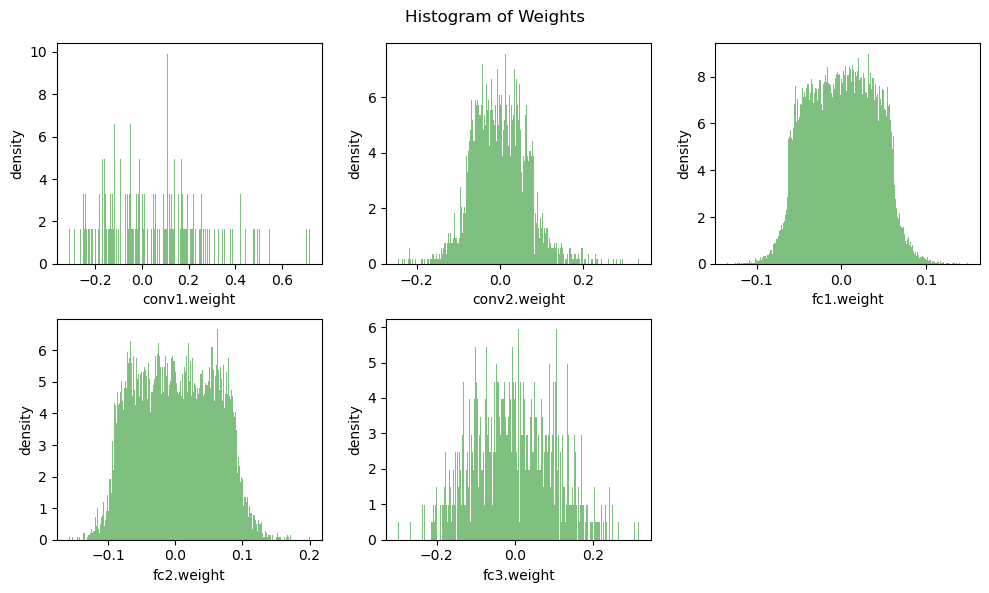

In [35]:
plot_weight_distribution(model)

In [36]:

# 计算每一层网络的稠密程度
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    num_nonzeros, num_elements = 0, 0
    for name,param in model.named_parameters():
        if param.dim() > 1:
            num_nonzeros = param.count_nonzero()
            num_elements = param.numel()
            dense = float(num_nonzeros) / num_elements
            num_parameters[name] = dense
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    
    bars = plt.bar(list(num_parameters.keys()), list(num_parameters.values()))

    # 在柱状图上添加数据标签
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, yval, va='bottom')  # va='bottom' 使得文本在柱状图上方

    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

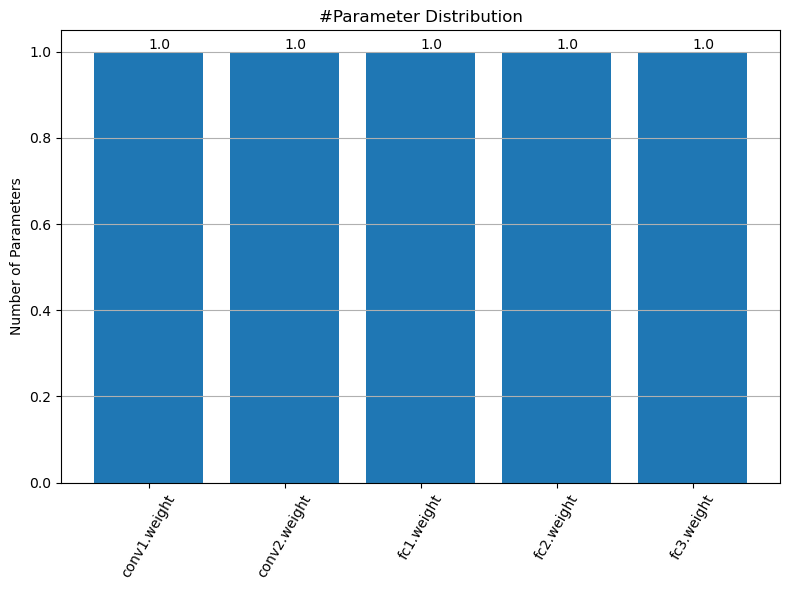

In [37]:
# 列出weight直方图
plot_num_parameters_distribution(model)

## 基于L1权重大小的剪枝

In [38]:
@torch.no_grad()
def prune_l1(weight, percentile=0.5):
    num_elements = weight.numel()

    # 计算值为0的数量
    num_zeros = round(num_elements * percentile)
    # 计算weight的重要性
    importance = weight.abs()
    # 计算裁剪阈值
    threshold = importance.view(-1).kthvalue(num_zeros).values
    # 计算mask
    mask = torch.gt(importance, threshold)
    
    # 计算mask后的weight
    weight.mul_(mask)
    return weight

In [39]:
# 裁剪conv2层
weight_pruned = prune_l1(model.conv2.weight, percentile=0.5)

In [40]:
# 替换原有model层
model.conv2.weight.data = weight_pruned

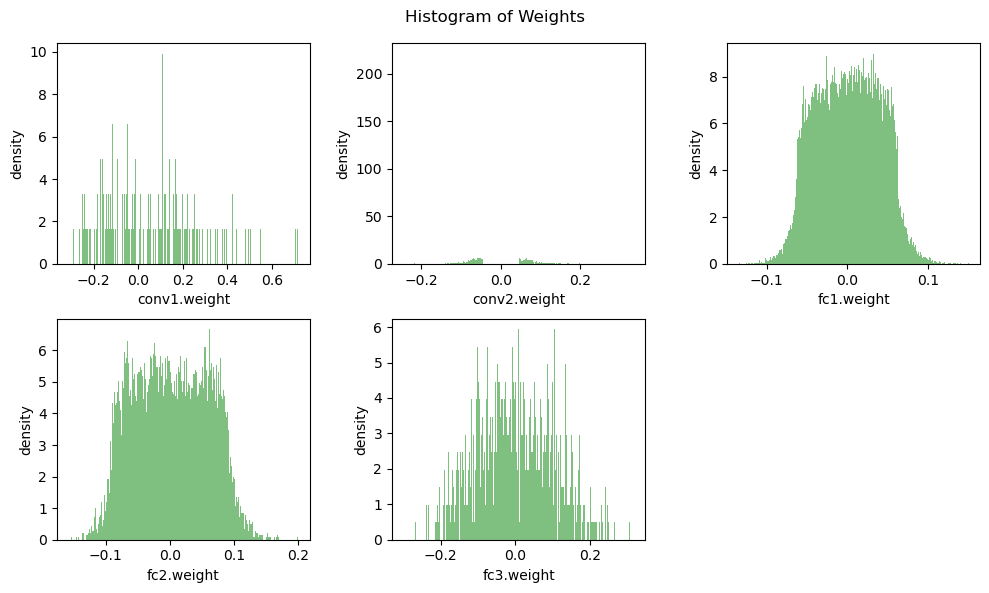

In [41]:
# 列出weight直方图
plot_weight_distribution(model)

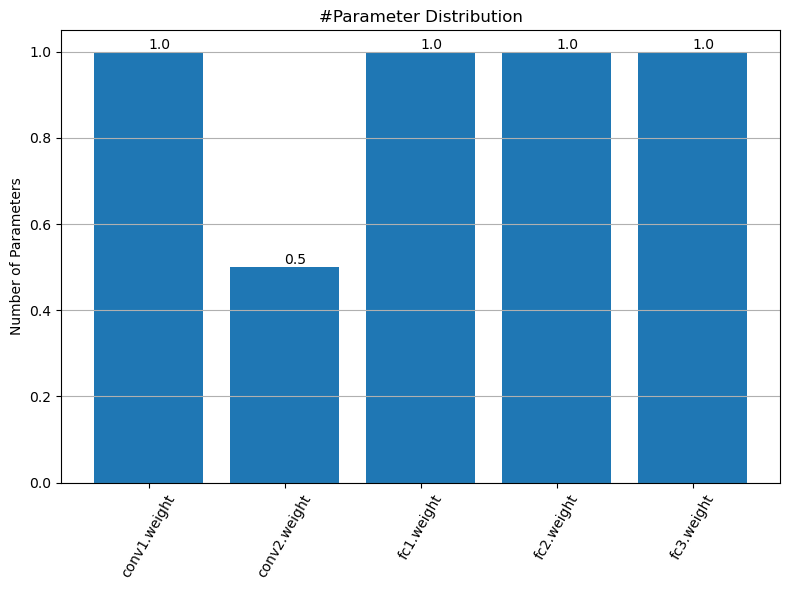

In [42]:
plot_num_parameters_distribution(model)

## 基于L2权重大小的剪枝

In [43]:
@torch.no_grad()
def prune_l2(weight, percentile=0.5):
    num_elements = weight.numel()

    # 计算值为0的数量
    num_zeros = round(num_elements * percentile)
    # 计算weight的重要性（使用L2范数，即各元素的平方）
    importance = weight.pow(2)
    # 计算裁剪阈值
    threshold = importance.view(-1).kthvalue(num_zeros).values
    # 计算mask
    mask = torch.gt(importance, threshold)
    
    # 计算mask后的weight
    weight.mul_(mask)
    return weight


In [44]:
# 裁剪fc1层
weight_pruned = prune_l2(model.fc1.weight, percentile=0.4)

In [45]:
# 替换原有model层
model.fc1.weight.data = weight_pruned

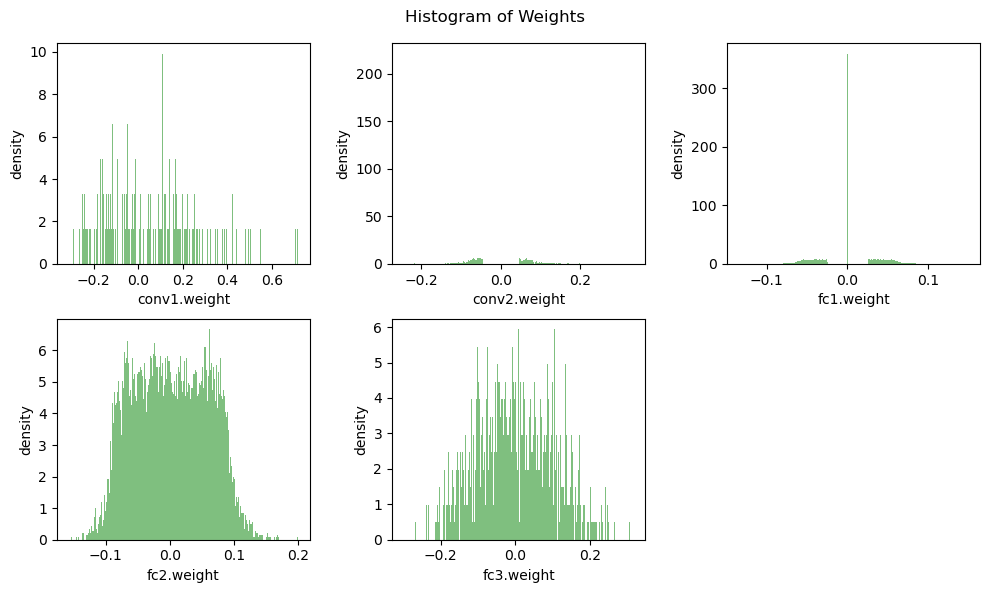

In [46]:
# 列出weight直方图
plot_weight_distribution(model)

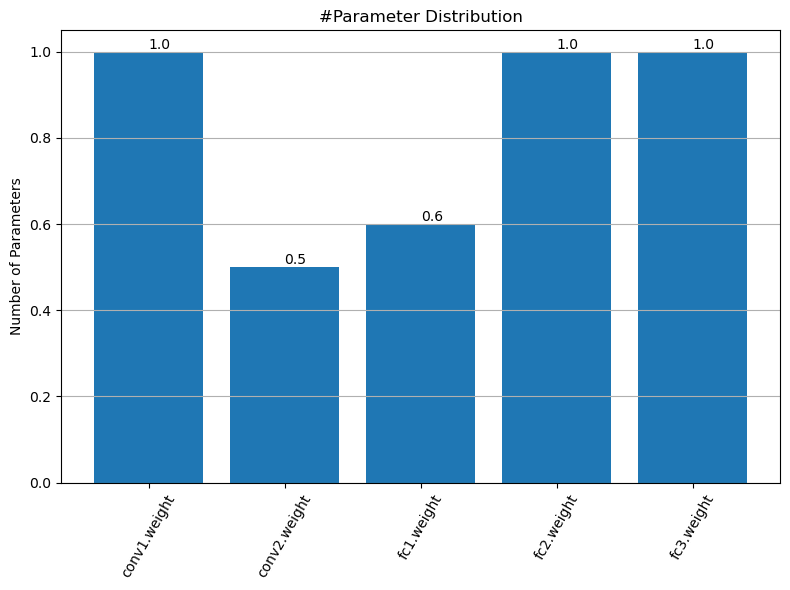

In [47]:
# 列出weight直方图
plot_num_parameters_distribution(model)

In [48]:
# 保存裁剪后的weight
torch.save(model.state_dict(), './model_pruned.pt')

## 基于梯度大小的剪枝

In [49]:
# 定义一个LeNet网络
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device=device)

In [50]:
# 加载梯度信息
gradients = torch.load('../ch02/model_gradients.pt')

In [51]:
# 加载参数信息
checkpoint = torch.load('../ch02/model.pt')
# 加载状态字典到模型
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [52]:
# 基于梯度幅度的修剪标准
def gradient_magnitude_pruning(model, percentile):
    for name, param in model.named_parameters():
        if 'weight' in name:
            mask = torch.abs(gradients[name]) >= percentile
            param.data *= mask.float()

In [53]:
@torch.no_grad()
def gradient_magnitude_pruning(weight, gradient, percentile=0.5):
    num_elements = weight.numel()

    # 计算值为0的数量
    num_zeros = round(num_elements * percentile)
    # 计算weight的重要性（使用L1范数）
    importance = gradient.abs()
    # 计算裁剪阈值
    threshold = importance.view(-1).kthvalue(num_zeros).values
    # 计算mask
    mask = torch.gt(importance, threshold)
    
    # 计算mask后的weight
    weight.mul_(mask)
    return weight

In [54]:
# 使用示例
percentile = 0.5
gradient_magnitude_pruning(model.fc2.weight, gradients['fc2.weight'], percentile)

Parameter containing:
tensor([[ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
        [ 0.0759, -0.0195,  0.0000,  ...,  0.0288, -0.0328, -0.0000],
        [ 0.0000, -0.0396, -0.0000,  ..., -0.0576, -0.0101,  0.0000],
        ...,
        [-0.0331, -0.0734,  0.0000,  ...,  0.1133, -0.0629, -0.0000],
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0444,  0.0000,  ..., -0.0475,  0.0651, -0.0000]],
       requires_grad=True)

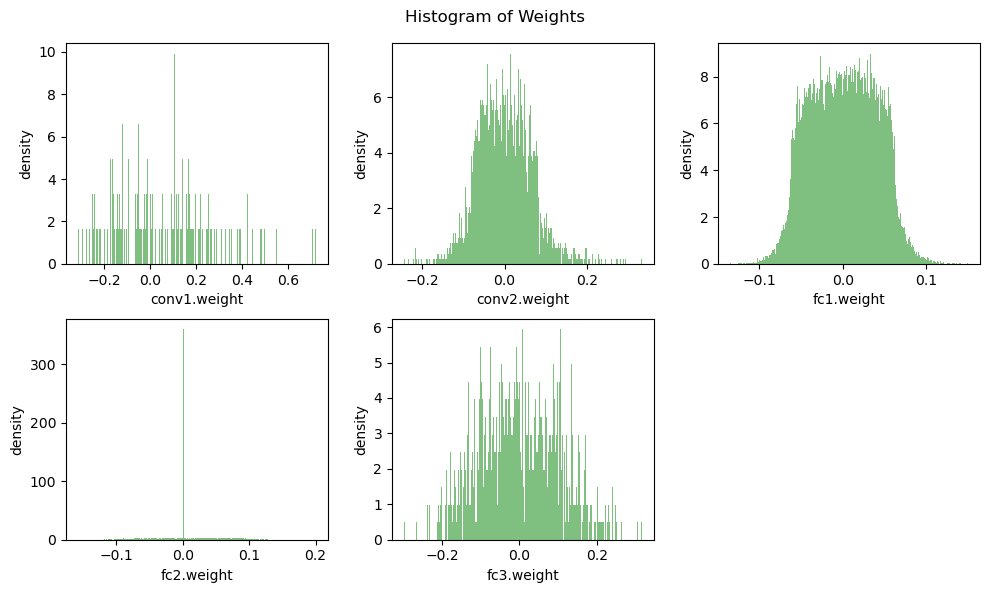

In [55]:
# 列出weight直方图
plot_weight_distribution(model)

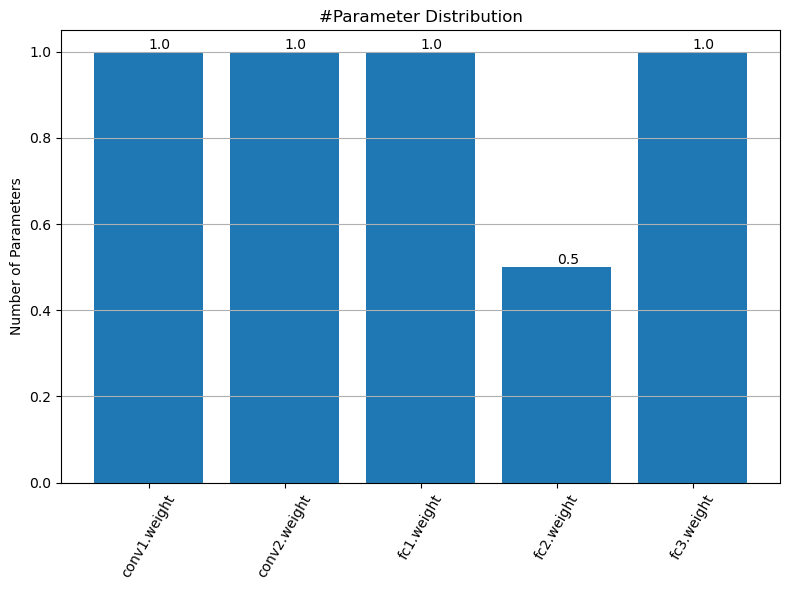

In [56]:
plot_num_parameters_distribution(model)